In [1]:
import os
import numpy as np

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)

from tensorflow.python.keras import backend as K

%matplotlib notebook
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from deepcell.applications import CellTrackingModel
from deepcell.applications import NuclearSegmentation
from deepcell_tracking import CellTracker
from deepcell.datasets.tracked import hela_s3

In [2]:
((X_train, y_train),(X_test, y_test)) = hela_s3.load_tracked_data()
X_test.shape

(36, 40, 216, 256, 1)

In [3]:
# Select a single movie to test models
mov = X_test[20]

<IPython.core.display.Javascript object>


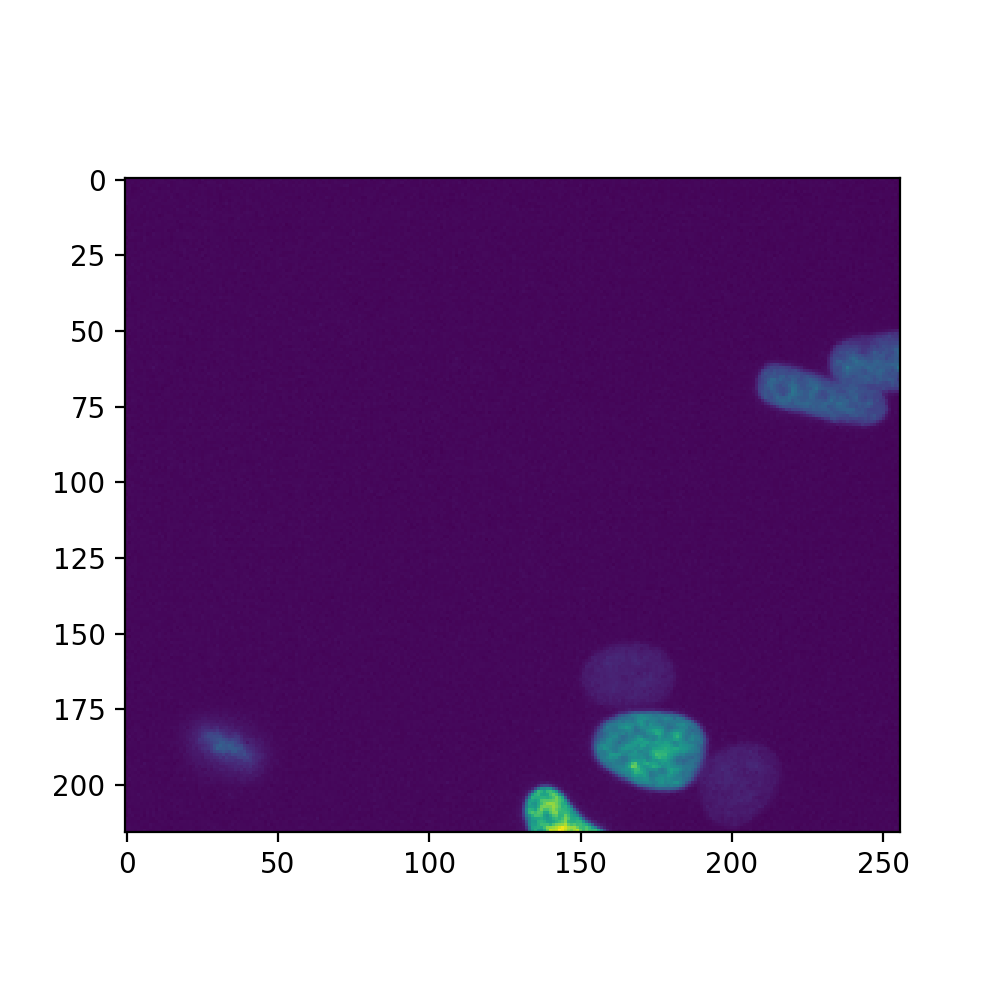

interactive(children=(IntSlider(value=0, description='index', max=39), Output()), _dom_classes=('widget-intera…

<function __main__.f1(index)>

In [18]:
fig1, axes1 = plt.subplots(figsize=(5, 5))

def f1(index):
    axes1.imshow(mov[index,...,0])
    return index

interact(f1, index=widgets.IntSlider(min=0, max=mov.shape[0]-1, step=1, value=0))

In [5]:
app = NuclearSegmentation()

W0410 21:47:09.749674 139803346495296 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [24]:
print('Training Resolution:', app.model_mpp, 'microns per pixel')

Training Resolution: 0.65 microns per pixel


In [20]:
label_mov = app.predict(mov, image_mpp=0.65)
label_mov = np.expand_dims(label_mov, axis=-1)
label_mov.shape

(40, 216, 256, 1)

<IPython.core.display.Javascript object>


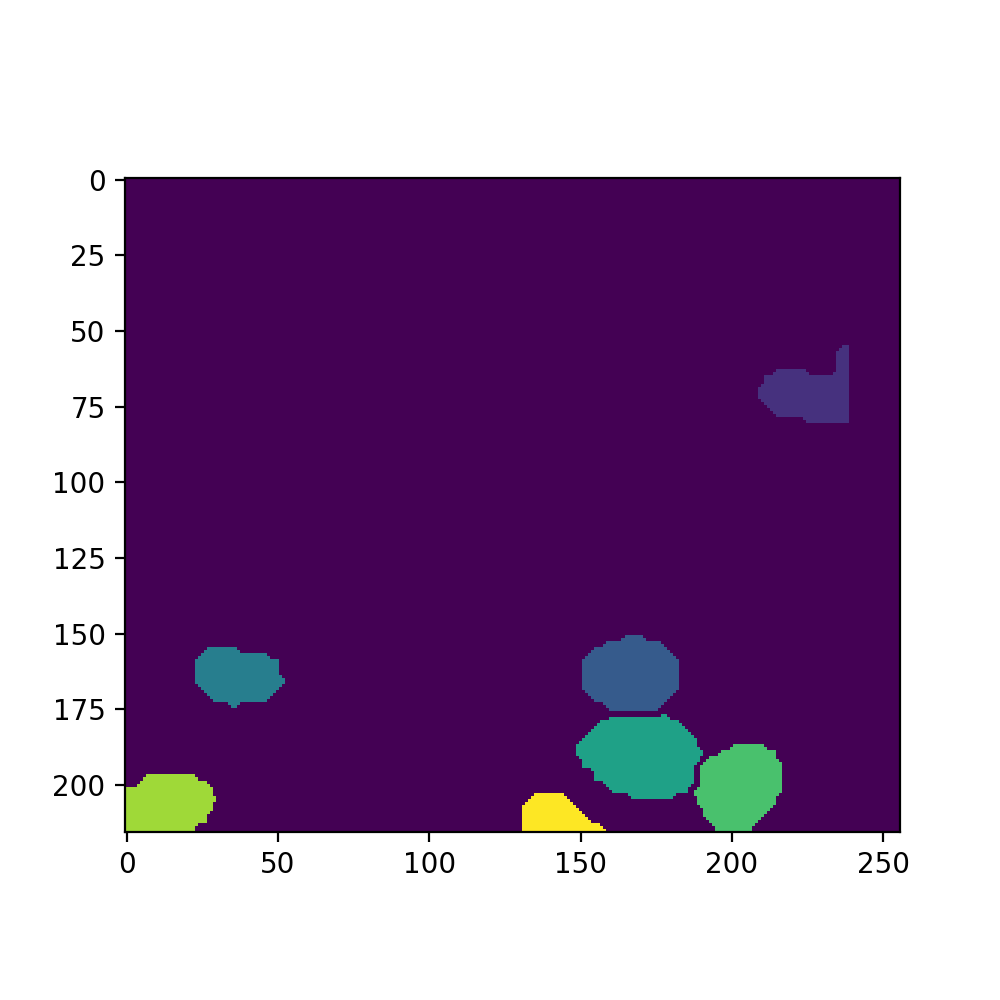

interactive(children=(IntSlider(value=0, description='index', max=39), Output()), _dom_classes=('widget-intera…

<function __main__.f2(index)>

In [21]:
fig2, axes2 = plt.subplots(figsize=(5, 5))

def f2(index):
    axes2.imshow(label_mov[index,...,0])
    return index

interact(f2, index=widgets.IntSlider(min=0, max=mov.shape[0]-1, step=1, value=0))

In [8]:
from deepcell_toolbox.processing import normalize

In [9]:
mov = mov.astype('float32')
norm_mov = []
for frame in range(mov.shape[0]):
    f = mov[frame,...,0]
    norm_mov.append(normalize(f))
    
norm_mov = np.stack(norm_mov, axis=0)
norm_mov = np.expand_dims(norm_mov, axis=-1)

In [11]:
tracking_model = CellTrackingModel()
cell_tracker = CellTracker(norm_mov, label_mov, tracking_model, birth=0.99, death=0.99, division=0.9)

In [12]:
cell_tracker.track_cells()
cell_tracker.dump('results.trk')

/usr/local/lib/python3.6/dist-packages/deepcell_tracking/tracking.py:721: FutureWarning: The coordinates keyword argument to skimage.measure.regionprops is deprecated. All features are now computed in rc (row-column) coordinates. Please remove `coordinates="rc"` from all calls to regionprops before updating scikit-image.
  props = regionprops(np.squeeze(roi), coordinates='rc')[0]
/usr/local/lib/python3.6/dist-packages/deepcell_tracking/tracking.py:685: FutureWarning: The coordinates keyword argument to skimage.measure.regionprops is deprecated. All features are now computed in rc (row-column) coordinates. Please remove `coordinates="rc"` from all calls to regionprops before updating scikit-image.
  props = regionprops(np.squeeze(roi), coordinates='rc')


In [13]:
# Open the track file
from deepcell_tracking.utils import load_trks

data = load_trks('results.trk')

lineage = data['lineages']  # linage information
X = data['X']  # raw X data
y = data['y']  # tracked y data

<IPython.core.display.Javascript object>


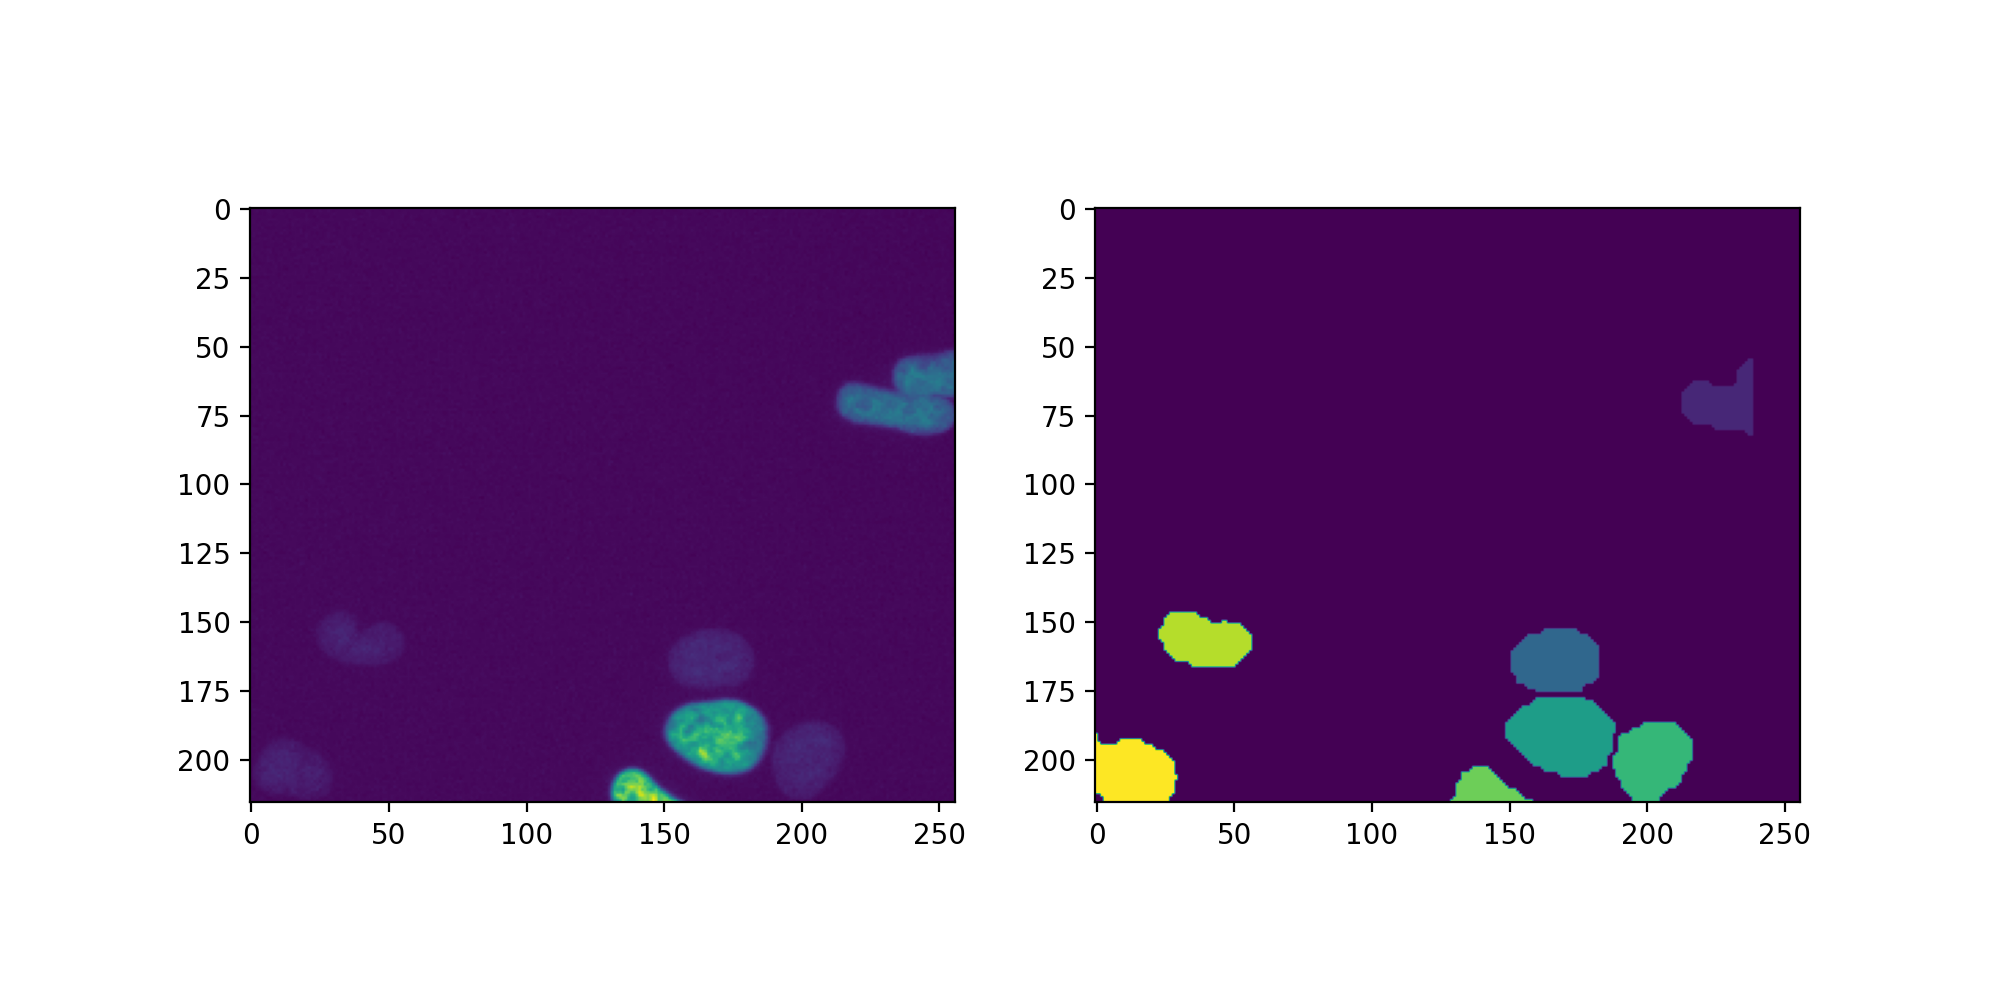

interactive(children=(IntSlider(value=0, description='index', max=39), Output()), _dom_classes=('widget-intera…

<function __main__.f(index)>

In [14]:
fig3, axes3 = plt.subplots(1,2, figsize=(10,5))

def f3(index):
    axes3[0].imshow(X[index,...,0])
    axes3[1].imshow(y[index,...,0])
    return index

interact(f3, index=widgets.IntSlider(min=0, max=y.shape[0]-1, step=1, value=0))

In [15]:
import imageio

# Save stacks
for i in range(X.shape[0]):
    if not os.path.isdir('nucleartracks'):
        os.mkdir('nucleartracks')
    
    new_image = X[i,...,0]
    imageio.imwrite('nucleartracks/image_%d.tiff' %i, new_image)

    label_image = y[i,...,0]
    imageio.imwrite('nucleartracks/label_%d.tiff' %i, label_image)